Well, dear reader, I know I haven't been posting very much lately. That's because I've been busy moving to a new city and working a new DS gig and  learning some new things, including Bayesian modeling. In particular I've been reading Richard McElreath's excellent book Statistical Rethinking, which I recommend to you as well. As a dedicated reader of this blog, I'm sure you're perfectly capable of digesting a 600 page statistics textbook on your own, but just for fun, today I present to you my 15 minute Bayesian statistics crash course. 

My primary goal is to illuminate the major steps in the Bayesian workflow, that way you have a mental framework where you can store and contextualize new pieces of information as you learn. My secondary goal is to give you an intuitive understanding of Bayesian modeling from two interconnected perspectives: a mathematical formulation based primarily in probability theory and a probabilistic programming approach based on writing code to generate random data. Each perspective supports the other, and they are both necessary to grasp the full picture. I will attempt to weave these two perspectives throughout the description of the workflow, which is motivated by a toy example we'll use throughout the post.

Let's do this! ➡️



## 🛠️ The Bayesian Workflow in 3 Steps

I consider the Bayesian workflow to have 3 major steps:

1. **Modeling** - specify the data generating process as a generative model
1. **Inference** - use the model, the observed data, and some inference algorithm to infer the values of unknown model parameters
1. **Interpretation** - summarize and interpret the inferred model parameters to answer your analysis questions

![The Bayesian Workflow: modeling, inference, interpretation.](modeling-inference-interpretation.png ".")


## ⚙️ Step 1. Modeling


### Modeling the Data Generating Process

In this step, we're going to build a *generative model*, i.e. a model that can simulate data similar to our observed data. If you're coming from ML, the key mental shift is to think about modeling the *data generating process (DGP)*, rather than curve-fitting the data itself. Practically this means our model is a set of random variables which relate to one another in some way and  from which we can draw realizations… random realizations, that is. You can invent a DGP as follows:



1. Identify the key variables in the system. 
2. Define each variable as a draw from some probability distribution, or in terms of the other variables. 
3. Use unknown parameters as needed in the probability distributions or in the functional relationships among the key variables.

In our RPS example, there is one key variable—Fritz's match outcome. We can define the match outcome variable as a random draw from some distribution, e.g. a Bernoulli distribution. The Bernoulli distribution has one parameter—the success probability—which corresponds here to Fritz's actual true win rate. Given some true win rate, we can simulate match outcomes by drawing realizations from the Bernoulli distribution.

$$ y_i \sim \text{Bernoulli}(\theta) $$

where $y_i = 0$ if Fritz loses to intern $i$ and $y_i = 1$ if he wins, and $i=1,\dots,N$ where $N=10$. In this DGP,  the parameter $\theta$ corresponds to Fritz's true win rate. 

This is a good start, but we can't simulate data from this model yet because $\theta$ has no particular value. So, what value should we use?


### Probability as Relative Plausibility

One of the key ideas in Bayesian modeling is that we can represent the relative plausibility of potential values of any unobserved variable using a probability distribution. 
Highly plausible values get higher probability, and less plausible values get lower probability.

*It is this view of probability as a measure of relative plausibility that distinguishes Bayesian statistics from Frequentist statistics, which views probability as the relative frequency of events.*

We don't know the true value of Fritz's RPS win rate, but even before collecting any data, we might have some contextual knowledge about how the world works which can provide some prior information about the relative plausibility of its possible values.
For me it's easiest to think in terms of how surprising a given true value would be.
I wouldn't be surprised at all if his win rate was near 0.5, but I would be shocked if it was 0.9 or 0.1, hence 0.5 has higher relative plausibility than 0.9 or 0.1.

Let's represent the prior relative plausibility of values of Fritz's RPS win rate with a probability distribution. Below are a few different probability distributions defined over the possible values $0 \le \theta \le 1$.

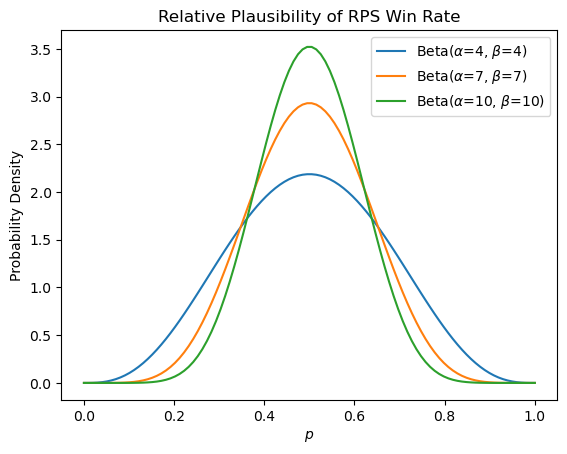

In [ ]:
#| code-fold: true
#| fig-alt: beta distribution priors

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import beta, bernoulli

# set colors for later
prior_color = "C0"
post_color = "C1"

# prior beta parameters
parameters = [
    (4, 4),
    (7, 7),
    (10, 10)
]

# plot the prior
x = np.linspace(0, 1, 100)
plt.figure()
for i, (alpha, beta_val) in enumerate(parameters):
    y = beta.pdf(x, alpha, beta_val)
    label = f'Beta($\\alpha$={alpha}, $\\beta$={beta_val})'
    plt.plot(x, y, label=label)

plt.xlabel("win rate (theta)")
plt.ylabel("Probability Density")
plt.title('Relative Plausibility of RPS Win Rate')
plt.legend()

Each of these PDFs has a mode at $\theta=0.5$ and decreases toward 0 and 1. They're all aligned with the relative plausibilities we discussed earlier. 

You can check the relative plausibility between two possible values of $\theta$ implied by a given pdf by taking the ratio of the height of the pdf at one value of $\theta$ versus the height at another value of $\theta$.

For example, let's compare $\theta=0.5$ to $\theta=0.7$ for a Beta(10, 10) prior.

In [185]:
beta.pdf(0.5, 10, 10) / beta.pdf(0.7, 10, 10)

np.float64(4.802710683776413)


The Beta(10, 10) distribution implies that a 0.5 win rate is about 5 times more plausible than a 0.7 win rate, which sounds, ahem, plausible.


### Priors

We can include this prior information about the relative plausibility of values of $\theta$  in our model as follows.

$$

\theta \sim \text{Beta}(10, 10)
\\
y_i \sim \text{Bernoulli}(\theta)

$$

In Bayesian parlance, we call the probability distribution that represents the relative plausibilities of an unobserved parameter its *prior distribution*, or simply its *prior*.
Notice that with the addition of the prior for $\theta$, our model is now fully generative, i.e. we can now write python code to simulate data from this model.


### Implementing the generative model

Now that we have our DGP complete with prior distributions for unknown parameters, we can implement some python code to simulate from our model.

In [186]:
np.random.seed(42)

def draw_from_prior(alpha_param, beta_param):
    return beta.rvs(alpha_param, beta_param)

def simulate_one_outcome(theta, N):
    y = bernoulli.rvs(theta, size=N)
    return {"theta": theta, "y": y, "sum_y": np.sum(y)}

# simulate a single outcome from the generative model
simulate_one_outcome(
    theta=draw_from_prior(alpha_param=10, beta_param=10), 
    N=10
)

{'theta': np.float64(0.5499465562958551),
 'y': array([1, 1, 1, 0, 0, 0, 1, 0, 0, 1]),
 'sum_y': np.int64(5)}

In [150]:
def simulate_outcomes(n_outcomes, alpha_param, beta_param, N):
    return pd.DataFrame([
        simulate_one_outcome(theta=draw_from_prior(alpha_param, beta_param), N=N)
        for _ in range(n_outcomes)
    ])

In [187]:
# set DGP parameters
alpha_param, beta_param = 10, 10
N = 10

# simulate outcomes from the generative model
outcome_df = simulate_outcomes(1_000, alpha_param, beta_param, N)
outcome_df.head()

,theta,y,sum_y
0,0.500196,"[1, 1, 0, 1, 1, 1, 1, 0, 1, 0]",7
1,0.446240,"[0, 1, 1, 1, 0, 0, 1, 0, 0, 0]",4
2,0.662485,"[1, 1, 0, 0, 0, 0, 1, 0, 1, 1]",5
3,0.515249,"[0, 1, 1, 0, 1, 0, 1, 0, 0, 1]",5
4,0.507255,"[1, 1, 0, 0, 1, 1, 1, 1, 0, 0]",6



Each time you run this simulation, you first draw a new value of $\theta$ from its prior, then that value is used in the Bernoulli distribution to draw an array of binary match win/loss observations. To help us summarize the match observations in each simulated outcome, we also compute the sum of the match values, i.e. the number of wins.


### Prior Predictive Check

But how do we know that the prior we chose is reasonable? There are two places we can look: (1) at the parameter itself and (2) at the downstream variables it influences. We already looked at the parameter itself by inspecting its pdf and thinking about the relative plausibilities it implies. To look at its impact on the downstream variables, we can simply run simulations from the model and inspect the outcome data it produces. If we see it's generating lots of highly implausible outcomes, then we know something isn't right. This process is called a *prior predictive check*, because we're checking the simulated outcomes (a.k.a. predictions) implied by the prior. Let's run our model simulation 1000 times and have a look at the distribution of the number of wins out of 10 matches that it predicts, i.e. the sum of the `y` variable from each simulation.

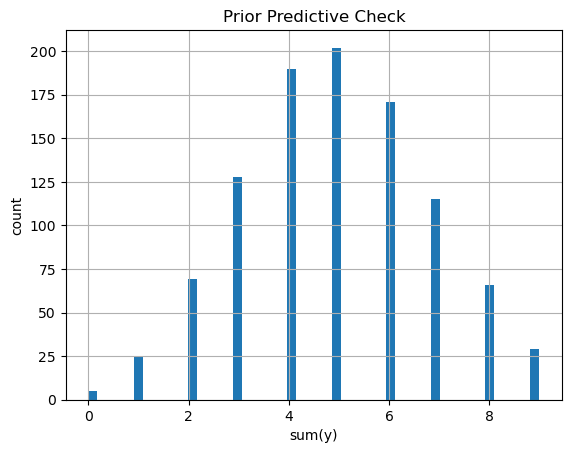

In [ ]:
#| code-fold: true
#| fig-alt: prior predictive check of number of match wins
outcome_df.hist("sum_y", bins=50, color=prior_color)
plt.xlabel('sum(y)')
plt.ylabel('count')
plt.title('Prior Predictive Check');

The histogram shows most of the simulations yield between 3 and 7 wins, with very few outcomes less than 3 or greater than 7. That seems pretty reasonable.

Let's look at what the prior predictive check might look like when things aren't quite right. 

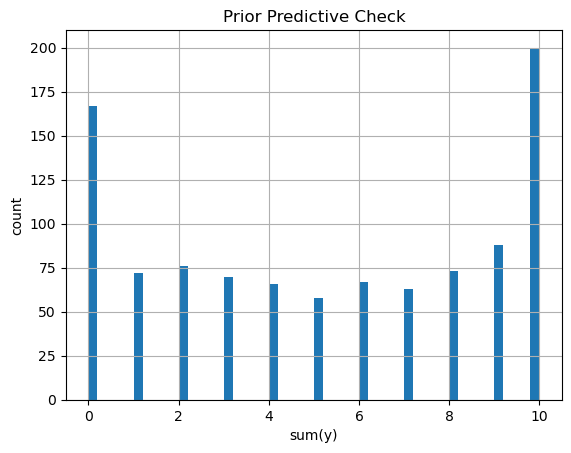

In [ ]:
#| code-fold: true
#| fig-alt: prior predictive check of the win rate, with unexpected distribution shape
simulate_outcomes(1_000, alpha_param=0.5, beta_param=0.5, N=10).hist("sum_y", bins=50, color=prior_color)
plt.xlabel('sum(y)')
plt.ylabel('count')
plt.title('Prior Predictive Check');

In this simulation, many of the outcomes are close to 0 or 10 wins out of 10. From our prior knowledge about RPS, we know it would be  possible but very unusual for someone to win either 0/10 or 10/10 matches. This tips us off that something isn't right with our priors. At this point we would iterate on our priors until we find something reasonable like our Beta(10, 10).

Once we've got our generative model and its  priors nailed down, we're ready to move from the modeling step to the inference step!




## 🧮 Step 2. Inference


### The Goal of Bayesian Inference

In the inference step, we use observed outcome data to infer the plausible values of the unobserved parameters. Whereas simulation passes information forward from parameters to outcomes, inference passes it backwards from observed outcomes to parameters.
It's analogous to model fitting or training in machine learning; it's the part where we use data to learn about the model parameters.
 The specific output of inference is the updated relative plausibility of the unknown model parameters. Whereas we represent the prior relative plausibilities with the prior distribution, we represent the posterior relative plausibilities (after incorporating information from the data) with the *posterior distribution*, or simply, the *posterior*. Like the prior, our model's posterior distribution is a probability density defined over the possible values of $\theta$, where larger values indicate higher relative plausibility.


### Analytical Formulation of Bayesian Inference

Let's nail down the mathematical formulation of Bayesian inference. We have data $y$ and parameter(s) $\theta$. These have a joint probability density $p(y, \theta)$. This joint distribution of data and parameters is defined by our generative model of the system—simulating data from our DGP is equivalent to drawing realizations from the joint distribution $p(y, \theta)$. Using the definition of conditional probability,, we can write the joint distribution as:

$$p(y, \theta) = p(y|\theta)p(\theta) $$

where 

* $p(\theta, y)$ is the *joint distribution* of parameter $\theta$  and data $y$
* $p(\theta)$ is the *prior * distribution of the parameter $\theta$
* $p(y|\theta)$ is the *likelihood*—the conditional distribution of observed data $y$ given parameter $\theta$. 

When we do inference we are interested in the relative plausibility of unknown parameter $\theta$ given data $y$, which we quantify as the conditional distribution of $\theta$ given $y$. Using Baye's Rule, we can write the posterior as

$$ p(\theta | y) = \frac{ p(y, \theta) } { p(y) } = \frac { p(y|\theta)p(\theta)  } { p(y) }  $$

where



* $p(\theta | y)$ is the *posterior* distribution of the parameter $\theta$
* $p(y)$ is the *marginal likelihood* of the data $y$

Technically, the joint distribution and the posterior are functions of *both* parameter $\theta$ and data $y$. But in practice when we compute the posterior, we'll have some actual observed data—say $y_{\text{obs}}$—so that $y$ is actually fixed at $y=y_{\text{obs}}$. Substituting the fixed value $y_{\text{obs}}$ in the posterior, we get

$$ p(\theta | y_{\text{obs}}) = \frac{ p(y_{\text{obs}}, \theta) } { p(y_{\text{obs}}) } =  \frac { p(y_{\text{obs}}|\theta)p(\theta)  } {  \int p(\theta|y_{\text{obs}})p(\theta) d \theta  }  $$

If we view $y_{\text{obs}}$ as fixed, then the posterior can be interpreted as just the slice of the joint distribution where $y=y_{\text{obs}}$. To get a proper conditional probability distribution, we just need to divide the sliced joint density function by the area under $p(\theta,y_{\text{obs}})$ along the $\theta$ axis. And guess what? That's exactly what the marginal likelihood is doing;  $p(y_{\text{obs}}) = \int p(\theta|y_{\text{obs}})p(\theta) d \theta$ is just the area under the sliced joint density, and it's there in the denominator to normalize the sliced joint density so that we get a proper conditional distribution for the posterior.


### Computing the Posterior using Grid Approximation

Let's compute the posterior using the formulas we cooked up in the previous section. Earlier when we wrote down our generative model, we already identified all the pieces we need:

* **the prior**—since $\theta \sim Beta(\alpha,\beta)$, $p(\theta)$ is the probability density function of a beta random variable.
* **the likelihood**—since $y_i \sim Bernoulli(\theta)$, the likelihood is the probability mass function of a Bernoulli random variable with parameter $\theta$... well, almost.

The one remaining detail to iron out is that our observed data $y_{\text{obs}}=[y_1,\dots,y_N]$ consists of $N=10$ observations of the binary match outcomes. Our likelihood needs to reflect the conditional probability of the entire dataset given $\theta$, not just a single observation. We know from probability theory that the joint probability of two independent events is the product of their individual probabilities. Therefore, assuming independence among our observations, the joint likelihood of the full dataset is the product of the likelihood of each observation.

$$ p(y_{\text{obs}}|\theta) = p(y_1,\dots,y_N|\theta) =  \prod_{i=1}^N p(y_i|\theta) $$

Let's implement the prior, the likelihood, the joint distribution, and the posterior in python and plot out the prior and the posterior distribution of the parameter $\theta$.


In [154]:
# 0. Defining the observed data

y_obs = np.array([1, 1, 0, 1, 0, 0, 1, 1, 1, 1])
sum_y_obs = np.sum(y_obs)

# 1. Functions for Prior and Likelihood

def prior(theta):
    return beta.pdf(theta, alpha_param, beta_param)

def likelihood(theta, y):
    product_of_likelihoods = 1.0
    for y_i in y:
        product_of_likelihoods *= bernoulli.pmf(y_i, p=theta)
    return product_of_likelihoods

# 2. Function for Joint Density p(y, theta)

def joint_density(theta, y):
    return likelihood(theta, y) * prior(theta)

# 3. Computing the Posterior by "Slicing" and Normalizing

def posterior_from_joint_slice(theta_values, y_observed_data):
    
    # compute grid of p(theta, y_obs) over values of theta and fixed y_obs
    unnormalized_posterior_values = np.array([
        joint_density(theta, y_observed_data) for theta in theta_values
    ])
    
    # numerical integration  to get marginal likelihood p(y_obs
    delta_theta = theta_values[1] - theta_values[0] 
    marginal_likelihood_approx = np.sum(unnormalized_posterior_values * delta_theta)
    
    # p(theta | y_obs) = p(theta, y_obs) / p(y_obs)
    normalized_posterior_values = unnormalized_posterior_values / marginal_likelihood_approx
    
    return normalized_posterior_values

In [189]:
# Define a grid of theta values
theta_grid = np.linspace(0.001, 0.999, 500) 

# Calculate prior over the grid of theta values
prior_values = np.array([prior(theta) for theta in theta_grid])

# Calculate likelihood values over the grid of theta values and fixed y_obs
likelihood_values = np.array([likelihood(theta, y_obs) for theta in theta_grid])

# Calculate the posterior over the grid of theta values and fixed y_obs
posterior_values = posterior_from_joint_slice(theta_grid, y_obs)


In [ ]:
#| code-fold: true
#| fig-alt: plot of prior and posterior computed with  grid approximation

# Plotting
plt.plot(theta_grid, prior_values, label=f'Prior p(theta) ~ Beta({alpha_param},{beta_param})', linestyle='--', color=prior_color)
plt.plot(theta_grid, posterior_values, label=f'Posterior p(theta|y_obs)', color=post_color, linewidth=2)
plt.title('Bayesian Inference: Prior, Likelihood, and Posterior')
plt.xlabel(r'$\theta$ (Probability of Match Win)')
plt.ylabel('Density')
plt.legend()
plt.grid(True, linestyle=':', alpha=0.7)
plt.xlim(0, 1)
plt.ylim(bottom=0)
plt.tight_layout()



From the figure we can see that while the prior is centered at $\theta=0.5$, the posterior is actually pulled slightly toward larger values of $\theta$ by the observed data, indicating increased relative plausibility on win rates greater than 0.5.

It's nice to see that the math  works and that we can successfully implement it in code, but grid approximation is a pedagogical endeavor. In practice, when models start to get complicated, we'll need a more flexible approach for finding the posterior.


### Sampling from the Posterior

It turns out that we can do inference using our generative model and our observed data without having to compute the likelihood directly. But while the forward problem of simulating data from the model is quite straightforward, it's less obvious how to approach the inverse problem of doing inference. There is no silver bullet here. In fact there are tons of different algorithms for doing inference on probabilistic models, but luckily, since virtually all  the important inference algorithms use sampling-based approaches, e.g. Hamiltonian Monte Carlo, Metropolis-Hastings, and Variational Inference, no matter which algorithm we use under the hood, we'll end up with the same kind of output at the end—samples of the unknown parameters which have been drawn from the posterior.

To get some intuition for how we can do inference by sampling from the generative model,, we're going to implement an inference algorithm called *rejection sampling*. The key idea is based on the insight we discussed earlier that the posterior is essentially a slice through the joint distribution where the data is fixed to what we actually observed. Since simulating from the generative model is equivalent to drawing samples from the joint distribution, isolating simulation outcomes where the data is equal to the observed data is equivalent to sampling from the sliced joint distribution, and hence equivalent to sampling from the posterior.

The algorithm is as follows



1. Generate a sample $(\theta^*,y^*)$ from the generative model.
2. Keep the sample if $y^*=y_{\text{obs}}$, otherwise discard it.
3. Repeat 1 and 2 until the desired number of retained samples is collected.
4. The retained samples of $\theta$ can be interpreted as samples from the posterior.

Let's do this in python. In our example, the order of the wins and losses over the $N=10$  match observations doesn't matter, so we'll focus on the number of wins. Since $\sum_iy_i=7$ in our observed data, we'll isolate the simulation outcomes where `sum_y` equals 7. 


Text(0.5, 1.0, 'Samples from the Generative Model')

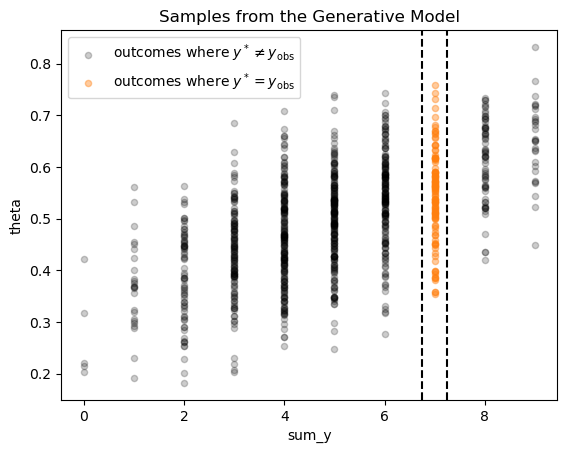

In [156]:
fig, ax = plt.subplots()
outcome_df.query('sum_y != @sum_y_obs').plot(x="sum_y", y="theta", kind="scatter", color="black", alpha=0.2, label="outcomes where $y^* \\ne y_{\\text{obs}}$", ax=ax)
outcome_df.query('sum_y == @sum_y_obs').plot(x="sum_y", y="theta", kind="scatter", color=post_color, alpha=0.4, label="outcomes where $y^* = y_{\\text{obs}}$", ax=ax)
ax.axvline(x=sum_y_obs-0.25, color="black", linestyle='--')
ax.axvline(x=sum_y_obs+0.25, color="black", linestyle='--')
plt.title("Samples from the Generative Model")



Boom! By isolating the outcomes where $y=y_{\text{obs}}$, we effectively have samples from the posterior. Let's draw a larger number of samples so we get an adequate sample from the posterior.


In [190]:
# drawing a large number of samples and isolating outcomes where y = y_obs
rejection_sampling_outcome_df = simulate_outcomes(10_000, alpha_param, beta_param, N).query('sum_y == @sum_y_obs')

# posterior samples from rejection sampling
posterior_samples = rejection_sampling_outcome_df["theta"]

Text(0.5, 1.0, 'Samples from the Posterior')

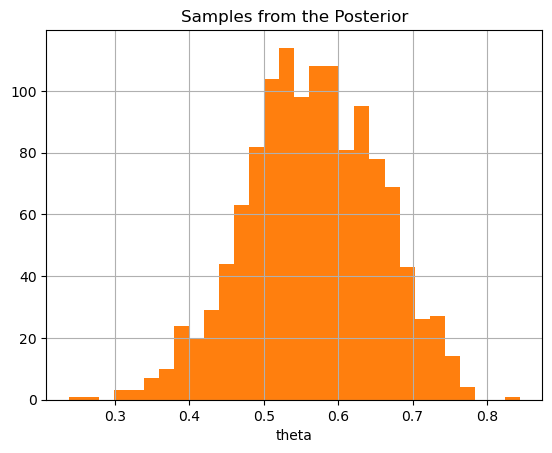

In [ ]:
#| code-fold: true
#| fig-alt: histogram of posterior
posterior_samples.hist(bins=30, color=post_color)
plt.xlabel("theta")
plt.title("Samples from the Posterior")



Now let's put all the pieces together. 

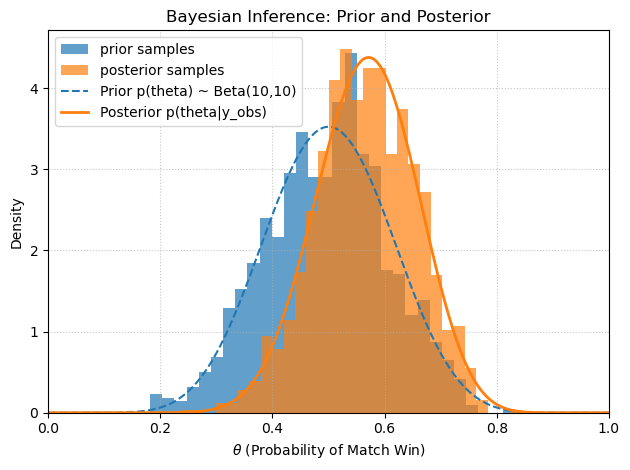

In [ ]:
#| code-fold: true
#| fig-alt: plot of prior and posterior as line plot from grid approximation and histogram from sampling

fig, ax = plt.subplots()
prior_samples = outcome_df["theta"]
prior_samples.hist(density=True, bins=30, alpha=0.7, color=prior_color, label="prior samples", ax=ax)
posterior_samples.hist(density=True, bins=30, alpha=0.7, color=post_color, label="posterior samples", ax=ax)
ax.plot(theta_grid, prior_values, label=f'Prior p(theta) ~ Beta({alpha_param},{beta_param})', linestyle='--', color=prior_color)
ax.plot(theta_grid, posterior_values, label=f'Posterior p(theta|y_obs)', color=post_color, linewidth=2)
plt.title('Bayesian Inference: Prior and Posterior')
plt.xlabel(r'$\theta$ (Probability of Match Win)')
plt.ylabel('Density')
plt.legend()
plt.grid(True, linestyle=':', alpha=0.7)
plt.xlim(0, 1)
plt.ylim(bottom=0)
plt.tight_layout()



In this figure we have:



1. the functional form of the prior
2. the functional form of the posterior from grid approximation
3. samples from the prior drawn directly from the generative model
4. and samples of the posterior obtained by applying rejection sampling to the generative model.

Great! Our sampling algorithms are generating samples from the prior and the posterior which are consistent with the functional forms we computed earlier!

While we used rejection sampling here, regardless of what sampling algorithm we choose, we'll end up with the same thing after inference—a set of samples from the posterior distribution for each unknown parameter. Once we have those samples, we're ready to move to the interpretation and analysis step.


## 3. Interpretation

In [160]:
print(f'point estimate of p: {np.mean(posterior_samples)}')

point estimate of p: 0.5655783348185507


In [161]:
print(f'89% credible interval of theta:: {np.quantile(posterior_samples, [0.055, 0.945])}')

89% credible interval of theta:: [0.42005907 0.70367915]


In [162]:
print(f'P[theta > 0.75]: {np.mean(posterior_samples > 0.75)}')

P[theta > 0.75]: 0.011933174224343675


### Posterior Predictive Samples

In [171]:
def simulate_posterior_predictive(posterior_samples, N):
    return pd.DataFrame([
        simulate_one_outcome(theta=theta, N=N)
        for theta in posterior_samples
    ])

posterior_predictive_df = simulate_posterior_predictive(posterior_samples, N)

Text(0, 0.5, 'probability mass')

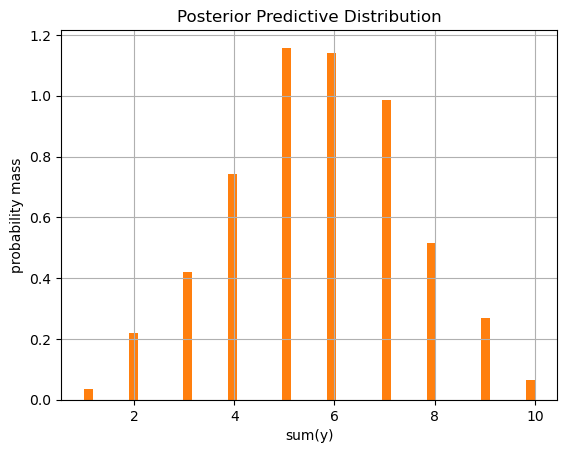

In [174]:
posterior_predictive_df["sum_y"].hist(density=True, bins=50, color=post_color)
plt.title("Posterior Predictive Distribution")
plt.xlabel("sum(y)")
plt.ylabel("probability mass")

In [181]:
print(f'Probability of winning >= 7 in next round: {np.mean(posterior_predictive_df["sum_y"] >= 7)}')

Probability of winning >= 7 in next round: 0.3309466984884646


In [182]:
# probability that Fritz's next round bill is less than or equal to $50

cost_per_drink = 12.0
posterior_predictive_df = (
    posterior_predictive_df
    .assign(losses = lambda x: N - x.sum_y)
    .assign(bill = lambda x: cost_per_drink * x.losses)
)

print(f'Probability next round bill <= $50: {np.mean(posterior_predictive_df["bill"] <= 50)}')

Probability next round bill <= $50: 0.5361972951471758
